In [1]:
# imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as VF
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader

from fastai.vision.gan import basic_generator, gan_critic
from fastai.torch_core import requires_grad, children
from fastai.callbacks import hook_outputs

from models import Generator

In [2]:
#load data into memory
data = np.load('brushstroke_data/' + 'episodes_42.npz')
stroke_data = data['strokes']

# define batch size
batch_size = 256

# define dataloaders and dataset used in training
actions = data['actions']
actions = torch.stack([torch.from_numpy(action).float() for action in actions])
strokes = torch.stack([torch.from_numpy(stroke).permute(2,0,1) for stroke in stroke_data])

# use generic pytorch datasets and dataloader classes
dataset = TensorDataset(strokes, actions)
dataloader = DataLoader(dataset, batch_size = 256, shuffle=False)

# define stroke transformer we will use during training
strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div(255))
                                  ])

In [3]:
# list saved generator models 
!ls generator_models

brushstroke_gan_non_adversarial_generator_param.pth


In [4]:
condition_dim = 12
image_size = 64
fc_dim = int(image_size * image_size)
channels = 3
n_extra_layers = 1

# instaniate generator
generator = Generator(condition_dim=condition_dim,
                     fc_dim=fc_dim,
                     in_size=image_size,
                     n_channels=channels,
                     n_extra_layers=n_extra_layers)

# load saved generator parameters
root = "generator_models/"
generator.load_state_dict(torch.load(root + "brushstroke_gan_non_adversarial_generator_param.pth"))

# visualize generator layers
generator

Generator(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, m

In [5]:
# list saved critic models
!ls critic_models

brushstroke_gan_non_adversarial_critic_param.pth


In [6]:
# instantiate critic
critic = gan_critic(nf=64)

# load saved critic parameters
root = "critic_models/"
critic.load_state_dict(torch.load(root + "brushstroke_gan_non_adversarial_critic_param.pth"))

# visualize critic layers
critic

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Dropout2d(p=0.075)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (2): MergeLayer()
    )
  )
  (3): Dropout2d(p=0.15)
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): SelfAttention(
      (query): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (key): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (value): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False

In [7]:
# define learning rate 
learning_rate = .0004

# define critic and generator optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.5, 0.9))


# define loss functions
critic_loss = F.binary_cross_entropy
base_loss = F.mse_loss

In [8]:
# define save directories for adversarial generator
root = 'adversarial_models/'
gen_model = 'brushstroke_gan_final_adversarial_generator_param.pth'
critic_model = 'brushstroke_gan_final_adversarial_critic_param.pth'

if not os.path.isdir(root):
    os.mkdir(root)

Device : cuda
Starting Adversarial Generator Training
epoch 1/100 | 1/391 complete!
critic loss: 1.625986933708191
generator loss: 0.023250222206115723
true
critic pred: 0.9505690932273865 real (true=1)


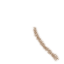

---
generated
critic pred: 0.9591482281684875 generated (true=0)


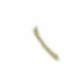

---
epoch 1/100 | 51/391 complete!
critic loss: 1.4617109298706055
generator loss: 0.032775264233350754
true
critic pred: 0.9112410545349121 real (true=1)


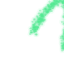

---
generated
critic pred: 0.9147231578826904 generated (true=0)


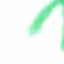

---
epoch 1/100 | 101/391 complete!
critic loss: 1.3186736106872559
generator loss: 0.04747555032372475
true
critic pred: 0.8587127923965454 real (true=1)


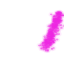

---
generated
critic pred: 0.9251886010169983 generated (true=0)


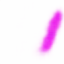

---
epoch 1/100 | 151/391 complete!
critic loss: 1.1931138038635254
generator loss: 0.06976191699504852
true
critic pred: 0.6906127333641052 real (true=1)


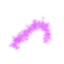

---
generated
critic pred: 0.6836028099060059 generated (true=0)


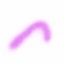

---
epoch 1/100 | 201/391 complete!
critic loss: 1.0903561115264893
generator loss: 0.10158830881118774
true
critic pred: 0.7329411506652832 real (true=1)


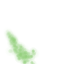

---
generated
critic pred: 0.5737280249595642 generated (true=0)


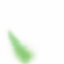

---
epoch 1/100 | 251/391 complete!
critic loss: 1.0150246620178223
generator loss: 0.1416267305612564
true
critic pred: 0.5481759309768677 real (true=1)


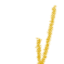

---
generated
critic pred: 0.5105922222137451 generated (true=0)


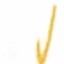

---
epoch 1/100 | 301/391 complete!
critic loss: 0.9632027745246887
generator loss: 0.17663277685642242
true
critic pred: 0.40646615624427795 real (true=1)


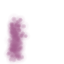

---
generated
critic pred: 0.5266535878181458 generated (true=0)


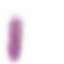

---
epoch 1/100 | 351/391 complete!
critic loss: 0.9261621832847595
generator loss: 0.2015456259250641
true
critic pred: 0.4806412160396576 real (true=1)


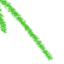

---
generated
critic pred: 0.4819265305995941 generated (true=0)


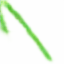

---
epoch 2/100 | 1/391 complete!
critic loss: 0.9028542041778564
generator loss: 0.2172786295413971
true
critic pred: 0.40470898151397705 real (true=1)


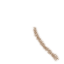

---
generated
critic pred: 0.3342078626155853 generated (true=0)


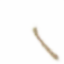

---
epoch 2/100 | 51/391 complete!
critic loss: 0.8800738453865051
generator loss: 0.23260021209716797
true
critic pred: 0.47657299041748047 real (true=1)


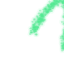

---
generated
critic pred: 0.5519482493400574 generated (true=0)


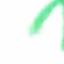

---
epoch 2/100 | 101/391 complete!
critic loss: 0.8620889782905579
generator loss: 0.24473533034324646
true
critic pred: 0.5702869296073914 real (true=1)


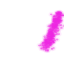

---
generated
critic pred: 0.569871187210083 generated (true=0)


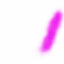

---
epoch 2/100 | 151/391 complete!
critic loss: 0.8474147319793701
generator loss: 0.2548447251319885
true
critic pred: 0.48847559094429016 real (true=1)


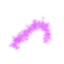

---
generated
critic pred: 0.5103169083595276 generated (true=0)


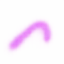

---
epoch 2/100 | 201/391 complete!
critic loss: 0.8351537585258484
generator loss: 0.26303112506866455
true
critic pred: 0.5370173454284668 real (true=1)


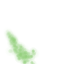

---
generated
critic pred: 0.5116645097732544 generated (true=0)


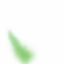

---
epoch 2/100 | 251/391 complete!
critic loss: 0.8248374462127686
generator loss: 0.27005884051322937
true
critic pred: 0.501774787902832 real (true=1)


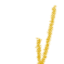

---
generated
critic pred: 0.5343034267425537 generated (true=0)


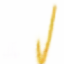

---
epoch 2/100 | 301/391 complete!
critic loss: 0.8161391615867615
generator loss: 0.2760118842124939
true
critic pred: 0.441313236951828 real (true=1)


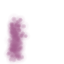

---
generated
critic pred: 0.5566158294677734 generated (true=0)


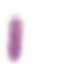

---
epoch 2/100 | 351/391 complete!
critic loss: 0.8086071014404297
generator loss: 0.2811097502708435
true
critic pred: 0.4938797056674957 real (true=1)


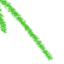

---
generated
critic pred: 0.4466811716556549 generated (true=0)


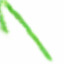

---
epoch 3/100 | 1/391 complete!
critic loss: 0.803104817867279
generator loss: 0.28479960560798645
true
critic pred: 0.5204048752784729 real (true=1)


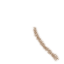

---
generated
critic pred: 0.4358326196670532 generated (true=0)


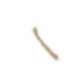

---
epoch 3/100 | 51/391 complete!
critic loss: 0.7970861792564392
generator loss: 0.28890261054039
true
critic pred: 0.49781081080436707 real (true=1)


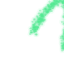

---
generated
critic pred: 0.6016347408294678 generated (true=0)


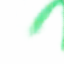

---
epoch 3/100 | 101/391 complete!
critic loss: 0.7917929291725159
generator loss: 0.292431503534317
true
critic pred: 0.5932541489601135 real (true=1)


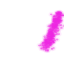

---
generated
critic pred: 0.5070429444313049 generated (true=0)


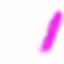

---


KeyboardInterrupt: 

In [9]:
# training
train_epoch = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device : {device}')

print('Starting Adversarial Generator Training')

# move generator to device
generator.to(device)

# move critic to device
critic.to(device)

critic_losses = []
generator_losses = []

for epoch in range(train_epoch):
    
    for num_iter, (stroke, action) in enumerate(dataloader):
        action = action.to(device)
        stroke = torch.stack([strokes_tfms(s) for s in stroke]).to(device)
        
        batch_size = stroke.shape[0]
        
        # create ground truth matrices
        true_matrix = torch.ones((batch_size,1), dtype=torch.float, requires_grad = False).to(device)
        false_matrix = torch.zeros((batch_size, 1), dtype=torch.float, requires_grad = False).to(device)
        
        # train critic first
        critic_optimizer.zero_grad()
        
        # compute true loss
        critic_true_predictions = torch.sigmoid(critic(stroke))
        critic_true_loss = critic_loss(critic_true_predictions, true_matrix)
        
        # compute generated loss
        generated_stroke = generator(action)
        critic_false_predictions = torch.sigmoid(critic(generated_stroke))
        critic_false_loss = critic_loss(critic_false_predictions, false_matrix)
        
        # average out losses 
        critic_training_loss = (critic_true_loss + critic_false_loss) / 2
        
        # step
        critic_training_loss.backward()
        critic_optimizer.step()
        
        critic_losses.append(critic_training_loss.data.item())
        
        # then train generator
        
        generator_optimizer.zero_grad()
        
        
        # get generated stroke & critic prediction
        generated_stroke = generator(action)
        critic_predictions = torch.sigmoid(critic(generated_stroke))
        
        # compute generator loss
        generator_training_loss = (critic_loss(critic_predictions, true_matrix) + base_loss(generated_stroke, stroke)) / 2
        
        # step
        generator_training_loss.backward()
        generator_optimizer.step()
        
        generator_losses.append(generator_training_loss.data.item())
        
        
        # print training info & display some examples
        if (num_iter % 50) == 0:
            print(f'epoch {epoch+1}/{train_epoch} | {num_iter+1}/{len(dataloader)} complete!')
                  
            print(f'critic loss: {torch.mean(torch.FloatTensor(critic_losses)).item()}')
            print(f'generator loss: {torch.mean(torch.FloatTensor(generator_losses)).item()}')
            # ---
            s = stroke[0].clone().cpu()
            print('true')
            print('critic pred:', critic_true_predictions[0].item(), 'real (true=1)')
            display(VF.to_pil_image(s))
            print('---')
            g = generated_stroke[0].clone().cpu()
            print('generated')
            print('critic pred:', critic_predictions[0].item(), 'generated (true=0)')
            display(VF.to_pil_image(g))
            print('---')

print('Saving Generator & Critic')

model_info_path = root + 'brushstroke_gan_final_' + 'adversarial_' + 'generator_info.pth'
with open(model_info_path, 'wb') as f:
    model_info = {
    'condition_dim': condition_dim,
    'fc_dim': fc_dim,
    'image_size': image_size,
    'channels': channels,
    'n_extra_layers': n_extra_layers,
    }
    torch.save(model_info, f)
# optional save models
# torch.save(critic.state_dict(), root + critic_model)      
# torch.save(generator.state_dict(), root + gen_model)      
# print('done')

In [ ]:
# check if models saved properly
!ls adversarial_models